In [1]:
import numpy as np
import glob
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import random
import requests
import psutil

from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.regularizers import l2
from keras.models import Sequential
from keras.utils import to_categorical
from keras.models import model_from_json
import keras.backend as K

from sklearn.metrics import confusion_matrix
from sklearn.utils import resample

import pandas as pd

import shap

Using TensorFlow backend.
/Users/areed145/opt/anaconda3/envs/keras/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.

/Users/areed145/opt/anaconda3/envs/keras/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.

/Users/areed145/opt/anaconda3/envs/keras/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.

/Users/areed145/opt/anaconda3/envs/keras/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning:

Passing (type, 1) 

In [2]:
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
# load weights into new model
model.load_weights('model.h5')
print('Loaded model from disk')

Instructions for updating:
Colocations handled automatically by placer.
Loaded model from disk


In [3]:
input_files = glob.glob('arrays/*.npz')
print(len(input_files))

Xs = []
ys = []
fs = []

for file in input_files:
    loaded = np.load(file)
    Xs.append(loaded['X'])
    ys.append(loaded['y'])
    fs.append(file)
    
X_ = np.array(Xs)
y_ = np.array(ys)
f_ = np.array(fs)

2600


In [4]:
samples = 5
Xs_r = []
ys_r = []
fs_r = []
for class_name in np.unique(y_):
    Xc_ = X_[y_==class_name]
    yc_ = y_[y_==class_name]
    fc_ = f_[y_==class_name]
    for sample in range(samples):
        idx = random.randint(0,len(Xc_)-1)
        Xs_r.append(Xc_[idx])
        ys_r.append(yc_[idx])
        fs_r.append(fc_[idx])
        
X = np.array(Xs_r)
y = np.array(ys_r)
f = np.array(fs_r)
y = to_categorical(y)

In [5]:
del(X_)
del(y_)
del(f_)
del(Xs)
del(ys)
del(fs)

[[5 0 0 0 0 0 0]
 [0 5 0 0 0 0 0]
 [0 0 5 0 0 0 0]
 [0 0 0 5 0 0 0]
 [1 0 0 0 4 0 0]
 [0 0 0 0 0 5 0]
 [0 0 0 0 0 0 5]]


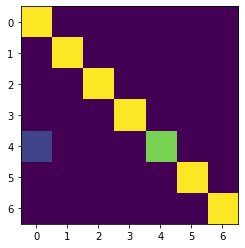

In [6]:
y_pred = model.predict(X)
cm = confusion_matrix(np.argmax(y, axis=1), np.argmax(y_pred, axis=1))
print(cm)
plt.imshow(cm)

In [7]:
state_map = {
    -99:'nan',
    0:'normal',
    1:'fluid_pound',
    2:'standing_valve',
    3:'sticking',
    4:'barrel_leak',
    5:'gas',
    6:'bad_data',
}

def map2layer(x, layer):
    feed_dict = dict(zip([model.layers[0].input], [x.copy()]))
    return K.get_session().run(model.layers[layer].input, feed_dict)

In [8]:
layer = 0
X_shap = X[:,:,:,:]
ranked_outputs = 2

In [9]:
explainer = shap.GradientExplainer(
    (model.layers[layer].input, model.layers[-1].output), 
    map2layer(X_shap.copy(), layer)
)

In [10]:
X_explain = X[::samples,:,:,:]
y_explain = np.argmax(y[::samples,:], axis=1)
f_explain = f[::samples]
shap_values, indexes = explainer.shap_values(
    map2layer(X_explain, layer), 
    ranked_outputs=ranked_outputs
)
index_names = np.vectorize(lambda x: state_map[x])(indexes)

In [11]:
for x in range(len(X_explain)):
    label = state_map[y_explain[x]]
    card = 'cards/'+f_explain[x][7:-4]+'.csv'
    df_card = pd.read_csv(card)
    channels = ['position','acceleration','load']
    titles = ['card: '+label]
    for ch in range(3):
        titles.append('truth: '+label+': '+channels[ch])
        for ro in range(ranked_outputs):
            titles.append(str(ro)+': '+index_names[x][ro]+': '+channels[ch])
    fig = make_subplots(
        rows=3,
        cols=ranked_outputs+2,
        specs=[
            [{'rowspan': 3}, {}, {}, {}],
            [None, {}, {}, {}],
            [None, {}, {}, {}]
        ],
        horizontal_spacing = 0.02,
        vertical_spacing = 0.05,
        shared_xaxes=True,
        shared_yaxes=True,
        subplot_titles=titles,
    )
    fig.add_trace(
            go.Scatter(
                x=df_card['pos(in)'].values,
                y=df_card['Load_1(lbs)'].values,
                mode='markers',
                marker=dict(
                    color=df_card['acc(in/s/s)'].values,
                    colorscale='Viridis',
                    showscale=False,
                ),
            ),
            row=1, col=1
        )
    for ch in range(3):
        fig.add_trace(
            go.Heatmap(
                z=np.rot90(np.rot90(np.rot90(X_explain[x][:,:,ch]))),
                colorscale='Viridis',
                showscale=False,
                xaxis='x2',
                yaxis='y2',
            ),
            row=ch+1, col=2
        )
        for ro in range(ranked_outputs):
            endpt = np.quantile(np.abs(shap_values[ro][x][:,:,ch]), 0.99)
            fig.add_trace(
                go.Heatmap(
                    z=np.rot90(np.rot90(np.rot90(shap_values[ro][x][:,:,ch]))),
                    zmin=-endpt,
                    zmax=endpt,
                    colorscale='Picnic',
                    showscale=False,
                    xaxis='x2',
                    yaxis='y2',
                ),
                row=ch+1, col=ro+3
            )
            
            
    fig.update_layout(
        height=300,
        width=1200,
#         title=label,
#         xaxis_title="x Axis Title",
#         yaxis_title="y Axis Title",
        margin=dict(l=50, r=10, t=40, b=10),
        xaxis2=dict(
            autorange=True,
            showgrid=False,
            ticks='',
            showticklabels=False
        ),
        yaxis2=dict(
            autorange=True,
            showgrid=False,
            ticks='',
            showticklabels=False
        ),
        font=dict(
#             family="Courier New, monospace",
            size=10,
            color="#7f7f7f"
        )
    )
    
    for i in fig['layout']['annotations']:
        i['font']['size'] = 8
    
#     fig.show()
    fig.write_image('images/'+label+'.svg')
    fig.write_image('images/'+label+'.png')
    fig.write_html('plots/'+label+'.html')